**Instructions for running this Julia notebook:**

If you do not have access to run a Julia Notebook. You can do the following in the Virtual machine provided

a. Follow the basic Instruction to install Julia:

https://medium.com/coffee-in-a-klein-bottle/install-julia-1-5-on-ubuntu-bb8be4b2571d

b. In a shell run anaconda-navigator:

Then open a jupyter notebook or jupyter lab and open the provided example.

c. Run the notebook. Observe that "PyPlot" is not installed.

Run the command suggested in the error mesaje ( in a Julia console "import Pkg; Pkg.add("PyPlot"))

In [1]:
using PyPlot
using LinearAlgebra
using Random

Random.seed!(12345);

LoadError: InitError: [91mPyError (PyImport_ImportModule[39m

[91mThe Python package matplotlib could not be imported by pyimport. Usually this means[39m
[91mthat you did not install matplotlib in the Python version being used by PyCall.[39m

[91mPyCall is currently configured to use the Python version at:[39m

[91m/home/osboxes/anaconda3/bin/python3[39m

[91mand you should use whatever mechanism you usually use (apt-get, pip, conda,[39m
[91metcetera) to install the Python package containing the matplotlib module.[39m

[91mOne alternative is to re-configure PyCall to use a different Python[39m
[91mversion on your system: set ENV["PYTHON"] to the path/name of the python[39m
[91mexecutable you want to use, run Pkg.build("PyCall"), and re-launch Julia.[39m

[91mAnother alternative is to configure PyCall to use a Julia-specific Python[39m
[91mdistribution via the Conda.jl package (which installs a private Anaconda[39m
[91mPython distribution), which has the advantage that packages can be installed[39m
[91mand kept up-to-date via Julia.  As explained in the PyCall documentation,[39m
[91mset ENV["PYTHON"]="", run Pkg.build("PyCall"), and re-launch Julia. Then,[39m
[91mTo install the matplotlib module, you can use `pyimport_conda("matplotlib", PKG)`,[39m
[91mwhere PKG is the Anaconda package that contains the module matplotlib,[39m
[91mor alternatively you can use the Conda package directly (via[39m
[91m`using Conda` followed by `Conda.add` etcetera).[39m

[91m) <class 'ImportError'>[39m
[91mImportError("/opt/julia-1.5.4/bin/../lib/julia/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /home/osboxes/anaconda3/lib/python3.8/site-packages/matplotlib/_path.cpython-38-x86_64-linux-gnu.so)")[39m
[91m  File "/home/osboxes/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py", line 113, in <module>[39m
[91m    from . import _api, _version, cbook, _docstring, rcsetup[39m
[91m  File "/home/osboxes/anaconda3/lib/python3.8/site-packages/matplotlib/rcsetup.py", line 27, in <module>[39m
[91m    from matplotlib.colors import Colormap, is_color_like[39m
[91m  File "/home/osboxes/anaconda3/lib/python3.8/site-packages/matplotlib/colors.py", line 56, in <module>[39m
[91m    from matplotlib import _api, _cm, cbook, scale[39m
[91m  File "/home/osboxes/anaconda3/lib/python3.8/site-packages/matplotlib/scale.py", line 22, in <module>[39m
[91m    from matplotlib.ticker import ([39m
[91m  File "/home/osboxes/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py", line 138, in <module>[39m
[91m    from matplotlib import transforms as mtransforms[39m
[91m  File "/home/osboxes/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py", line 49, in <module>[39m
[91m    from matplotlib._path import ([39m

during initialization of module PyPlot

# Exploring Low-Precision Training

Let's look at how our logistic regression model from the previous couple of demos is affected by training in low-precision floating-point arithmetic.

First, define a low-precision numeric type in Julia.

In [2]:
import Base.convert
import Base.length
import Base.zero
import Base.one
import Base.typemin
import Base.transpose
import Base.sqrt
import LinearAlgebra.dot
import Base.exp
import Base.expm1
import Base.isless
import Base.log
import Base.+
import Base.-
import Base.*
import Base./


abstract type NoDynamicBias end;

# NB = number of mantissa bits
# NE = number of exponent bits
# EBIAS = extra exponent bias; default should be 0 which corresponds to a bias of (1 << (NE-1)) - 1
# RM = rounding mode
struct SimFP{NB,NE,EBIAS,RM} <: Number
  v::Float64;
  SimFP{NB,NE,EBIAS,RM}(x::Float64) where {NB,NE,EBIAS,RM} = new{NB,NE,EBIAS,RM}(quantize(x, SimFP{NB,NE,EBIAS,RM})); # NB, NE, EBIAS, RM));
end

function Float64(x::SimFP)
  return x.v
end

function convert(::Type{Float64}, x::SimFP)
  return x.v
end

function convert(::Type{SimFP{NB,NE,EBIAS,RM}}, x::SimFP) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(x.v)
end

function convert(::Type{SimFP{NB,NE,EBIAS,RM}}, x::Float64) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(x)
end

function convert(::Type{SimFP{NB,NE,EBIAS,RM}}, x) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(convert(Float64, x))
end

function (::Type{SimFP{NB,NE,EBIAS,RM}})(x) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(convert(Float64, x))
end

# function convert(::Type{T}, x::SimFP) where {T}
#   return convert(T, x.v)
# end

function zero(::Type{SimFP{NB,NE,EBIAS,RM}}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(0.0)
end

function zero(::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(0.0)
end

function one(::Type{SimFP{NB,NE,EBIAS,RM}}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(1.0)
end

function one(::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(1.0)
end

function typemin(::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(-realmax(Float64))
end

function typemax(::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(realmax(Float64))
end

function transpose(x::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return x
end

function sqrt(x::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(sqrt(x.v))
end

function dot(x::SimFP{NB,NE,EBIAS,RM}, y::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(dot(x.v, y.v))
end

function exp(x::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(exp(x.v))
end

function expm1(x::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(expm1(x.v))
end

function log(x::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(log(x.v))
end

function isless(x::SimFP{NB,NE,EBIAS,RM}, y::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return isless(x.v, y.v)
end

abstract type RoundingModeNearest end;
abstract type RoundingModeRandom end;

abstract type RoundingModeNearestFast end;
abstract type RoundingModeRandomFast end;

function quantize(x::Float64, nb::Int64, ne::Int64, ::Type{NoDynamicBias}, rm)
  return quantize(x, nb, ne, 0, rm);
end

function quantize(x::Float64, ::Type{SimFP{nb,ne,ebias,RoundingModeNearest}}) where {nb,ne,ebias}
  if (x == 0.0)
    return x;
  end
  # @assert(ne <= 11);
  xi = reinterpret(Int64, x);
  xir = (xi + 1 << (51 - nb)) & (~((1 << (52 - nb)) - 1));
  if (ne < 11)
    xir_pos = xir & (~(1 << 63));
    xir_sign = xir & (1 << 63);
    bias = ebias + (1 << (ne-1)) - 1;
    qf_max = (((bias + 1 + 1023) << nb) - 1) << (52 - nb);
    qf_min = (1023 - bias + 1) << 52;
    qf_min_d2 = (1023 - bias) << 52;
    if (xir_pos > qf_max)
      return reinterpret(Float64, qf_max | xir_sign);
    elseif (xir_pos < qf_min_d2)
      return Float64(0.0);
    elseif (xir_pos < qf_min)
      return reinterpret(Float64, qf_min | xir_sign);
    end
  end
  return reinterpret(Float64, xir);
end

function quantize(x::Float64, ::Type{SimFP{nb,ne,ebias,RoundingModeRandom}}) where {nb,ne,ebias}
  if (x == 0.0)
    return x;
  end
  # @assert(ne <= 11);
  mask = (1 << (52 - nb)) - 1;
  xi = reinterpret(Int64, x);
  xir = (xi + (rand(Int64) & mask)) & (~mask);
  if (ne < 11)
    xir_pos = xir & (~(1 << 63));
    xir_sign = xir & (1 << 63);
    bias = ebias + (1 << (ne-1)) - 1;
    qf_max = (((bias + 1 + 1023) << nb) - 1) << (52 - nb);
    qf_min = (1023 - bias + 1) << 52;
    if (xir_pos > qf_max)
      return reinterpret(Float64, qf_max | xir_sign);
    elseif (xir_pos < qf_min)
      xfr_pos = reinterpret(Float64, xir_pos);
      ff_min = reinterpret(Float64, qf_min);
      if (xfr_pos / ff_min > rand())
        return reinterpret(Float64, qf_min | xir_sign);
      else
        return Float64(0.0)
      end
    end
  end
  return reinterpret(Float64, xir);
end

function quantize(x::Float64, ::Type{SimFP{nb,ne,ebias,RoundingModeNearestFast}}) where {nb,ne,ebias}
  xi = reinterpret(Int64, x);
  xir = (xi + 1 << (51 - nb)) & (~((1 << (52 - nb)) - 1));
  return reinterpret(Float64, xir);
end

function quantize(x::Float64, ::Type{SimFP{nb,ne,ebias,RoundingModeRandomFast}}) where {nb,ne,ebias}
  mask = (1 << (52 - nb)) - 1;
  xi = reinterpret(Int64, x);
  xir = (xi + (rand(Int64) & mask)) & (~mask);
  return reinterpret(Float64, xir);
end

function +(x::SimFP{NB,NE,EBIAS,RM}, y::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(x.v + y.v)
end

function -(x::SimFP{NB,NE,EBIAS,RM}, y::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(x.v - y.v)
end

function *(x::SimFP{NB,NE,0,RM}, y::SimFP{NB,NE,EBIASY,RM}) where {NB,NE,EBIASY,RM}
  return SimFP{NB,NE,EBIASY,RM}(x.v * y.v)
end

function *(x::SimFP{NB,NE,EBIASX,RM}, y::SimFP{NB,NE,0,RM}) where {NB,NE,EBIASX,RM}
  return SimFP{NB,NE,EBIASX,RM}(x.v * y.v)
end

function *(x::SimFP{NB,NE,0,RM}, y::SimFP{NB,NE,0,RM}) where {NB,NE,RM}
  return SimFP{NB,NE,0,RM}(x.v * y.v)
end

function *(x::SimFP{NB,NE,EBIASX,RM}, y::SimFP{NB,NE,EBIASY,RM}) where {NB,NE,EBIASX,EBIASY,RM}
  return SimFP{NB,NE,EBIASX+EBIASY,RM}(x.v * y.v)
end

function /(x::SimFP{NB,NE,EBIASX,RM}, y::SimFP{NB,NE,0,RM}) where {NB,NE,EBIASX,RM}
  return SimFP{NB,NE,EBIASX,RM}(x.v / y.v)
end

function /(x::SimFP{NB,NE,EBIASX,RM}, y::SimFP{NB,NE,EBIASY,RM}) where {NB,NE,EBIASX,EBIASY,RM}
  return SimFP{NB,NE,EBIASX-EBIASY,RM}(x.v / y.v)
end

function /(x::SimFP{NB,NE,EBIAS,RM}, y::Int64) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(x.v / Float64(y))
end

function -(x::SimFP{NB,NE,EBIAS,RM}) where {NB,NE,EBIAS,RM}
  return SimFP{NB,NE,EBIAS,RM}(-x.v)
end

function +(::Type{NoDynamicBias}, ::Type{NoDynamicBias})
  return NoDynamicBias;
end

function -(::Type{NoDynamicBias}, ::Type{NoDynamicBias})
  return NoDynamicBias;
end

function rescale_bias(::Type{SimFP{NB,NE,EBIAS,RM}}, hint) where {NB,NE,EBIAS,RM}
  hint64 = Float64(hint);
  eb = -Int64(floor(log2(hint64)));
  println("based on hint ($(hint64)), setting exponent bias to: $(eb)")
  return SimFP{NB,NE,eb,RM};
end

function rescale_bias(::Type{SimFP{NB,NE,NoDynamicBias,RM}}, hint) where {NB,NE,RM}
  return SimFP{NB,NE,NoDynamicBias,RM};
end

function rescale_bias(::Type{Float16}, hint)
  return Float16
end

function rescale_bias(::Type{Float32}, hint)
  return Float32
end

function rescale_bias(::Type{Float64}, hint)
  return Float64
end

rescale_bias (generic function with 5 methods)

In [3]:
# generate the data
Random.seed!(424242)
d = 50;
N = 10000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt.(sum(X.^2; dims=2));
Y = (1 ./ (1 .+ exp.(-X * wtrue)) .>= rand(N)) .* 2 .- 1;
sigma = 1e-3;

LoadError: [91mUndefVarError: Random not defined[39m

In [4]:
w0 = zeros(d);

LoadError: [91mUndefVarError: d not defined[39m

In [5]:
function sgd_logreg(w0::Array{T,1}, alpha::T, gamma::T, X::Array{T,2}, Y::Array{T,1}, sigma::T, niters::Int64, wopt::Array{T,1}) where {T<:Number}
    w = w0
    (N, d) = size(X)
    dist2_to_optimum = zeros(niters)
    for k = 1:niters
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        w += -alpha * sigma * w + alpha * xi * yi / (one(alpha) .+ exp.(yi * dot(xi, w)));
        dist2_to_optimum[k] = sum((w - wopt).^2);
    end
    return (w, dist2_to_optimum);
end

function sgd_logreg(::Type{T}, w0, alpha, gamma, X, Y, sigma, niters, wopt) where {T<:Number}
    (w, dist2_to_optimum) = sgd_logreg(T.(w0), T(alpha), T(gamma), T.(X), T.(Y), T.(sigma), niters, T.(wopt))
    return (Float64.(w), Float64.(dist2_to_optimum));
end

sgd_logreg (generic function with 2 methods)

In [6]:
# find the true minimum
function newton_logreg(w0, X, Y, sigma, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 .+ exp.(Y .* (X * w)))) + N * sigma * w;
        H = X' * ((1 ./ ((1 .+ exp.(Y .* (X * w))) .* (1 .+ exp.(-Y .* (X * w))))) .* X) + N * sigma * I;
        w = w - H \ g;
        # println("gradient norm: $(norm(g))")
    end
    return w
end

wopt = newton_logreg(wtrue, X, Y, sigma, 20);

LoadError: [91mUndefVarError: wtrue not defined[39m

In [7]:
# define low-precision types

Float16Rand = SimFP{10,5,0,RoundingModeRandom};
Float16Near = SimFP{10,5,0,RoundingModeNearest};

In [8]:
alpha = 0.1;

Random.seed!(123456);
(w, dto) = sgd_logreg(Float32, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

Random.seed!(123456);
(w2, dto2) = sgd_logreg(Float16Rand, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

Random.seed!(123456);
(w3, dto3) = sgd_logreg(Float16Near, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

LoadError: [91mUndefVarError: Random not defined[39m

In [9]:
plot(dto; label="Float32");
plot(dto2; label="Float16 (random)");
plot(dto3; label="Float16 (nearest)");
legend();
ylim([0,10]);
#xlim([95000,100000])

LoadError: [91mUndefVarError: plot not defined[39m

In [10]:
alpha = 0.1;

Float12Rand = SimFP{6,5,0,RoundingModeRandom};
Float12Near = SimFP{6,5,0,RoundingModeNearest};
#Float12Rand = SimFP{7,8,0,RoundingModeRandom};
#Float12Near = SimFP{7,8,0,RoundingModeNearest};

Random.seed!(123456);
(w, dto) = sgd_logreg(Float32, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

Random.seed!(123456);
(w2, dto2) = sgd_logreg(Float12Rand, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

Random.seed!(123456);
(w3, dto3) = sgd_logreg(Float12Near, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

LoadError: [91mUndefVarError: Random not defined[39m

In [11]:
plot(dto; label="Float32");
plot(dto2; label="Float12 (random)");
plot(dto3; label="Float12 (nearest)");
legend();
ylim([0,10]);

LoadError: [91mUndefVarError: plot not defined[39m

In [12]:
alpha = 1.0;

Float8Rand = SimFP{4,5,0,RoundingModeRandom};
Float8Near = SimFP{4,5,0,RoundingModeNearest};

Random.seed!(123456);
(w, dto) = sgd_logreg(Float32, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

Random.seed!(123456);
(w2, dto2) = sgd_logreg(Float8Rand, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

Random.seed!(123456);
(w3, dto3) = sgd_logreg(Float8Near, w0, alpha, sigma, X, Y, sigma, 100000, wopt);

LoadError: [91mUndefVarError: Random not defined[39m

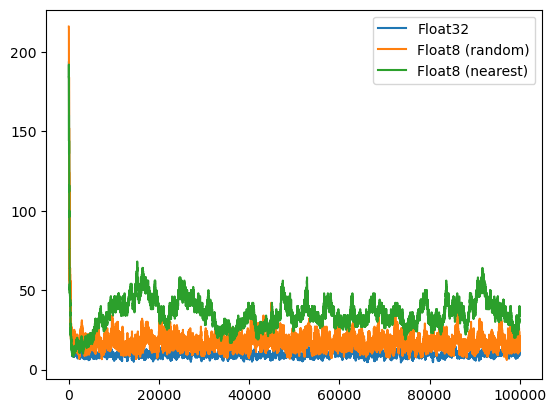

In [61]:
plot(dto; label="Float32");
plot(dto2; label="Float8 (random)");
plot(dto3; label="Float8 (nearest)");
legend();